In [ ]:
import numpy as np

#np.random.seed(1234)
import time
import os
import pandas as pd
from numpy.linalg import norm
import math

import scanpy as sc
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

from os import path
import random


: 

In [2]:
import nsf_paper

In [5]:
#from nsf_paper import utils   
from nsf_paper.utils import preprocess,visualize,misc

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


2026-01-07 17:53:52.394146: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-07 17:53:53.931840: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ImportError: cannot import name 'renames_v2' from 'tensorflow.tools.compatibility' (/home/u3553426/.local/lib/python3.12/site-packages/tensorflow/tools/compatibility/__init__.py)

In [2]:
from SparseAEH import MixedGaussian
from plot import plot_clusters

ModuleNotFoundError: No module named 'plot'

In [6]:
import spatialdm as sdm
from spatialdm.datasets import dataset
import spatialdm.plottings as pl

import matplotlib.pyplot as plt
print("SpatailDM version: %s" %sdm.__version__)

ModuleNotFoundError: No module named 'spatialdm'

# NPC1-genes

In [7]:
adata_impt_all = sc.read_h5ad('NPC1/patient1_adata_all_pvalue.h5ad')
spatialxy = np.column_stack((np.array(adata_impt_all.obs['x']), np.array(adata_impt_all.obs['y'])))
adata_impt_all.obsm['spatial'] = spatialxy

OSError: Unable to synchronously open file (file signature not found)

In [7]:
gaussian_0 = MixedGaussian(adata_impt_all.obsm['spatial'],group_size=16,d=30,l=1e-5)
cluster_0 = gaussian_0.run_cluster(adata_impt_all.X,4,iter=50,init_mean='k_means',threshold=8e-2) 

/mnt/jackywang/nfs_share/anaconda3/envs/biotransfer/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0
Iteration 1
updating variance
Iteration 2


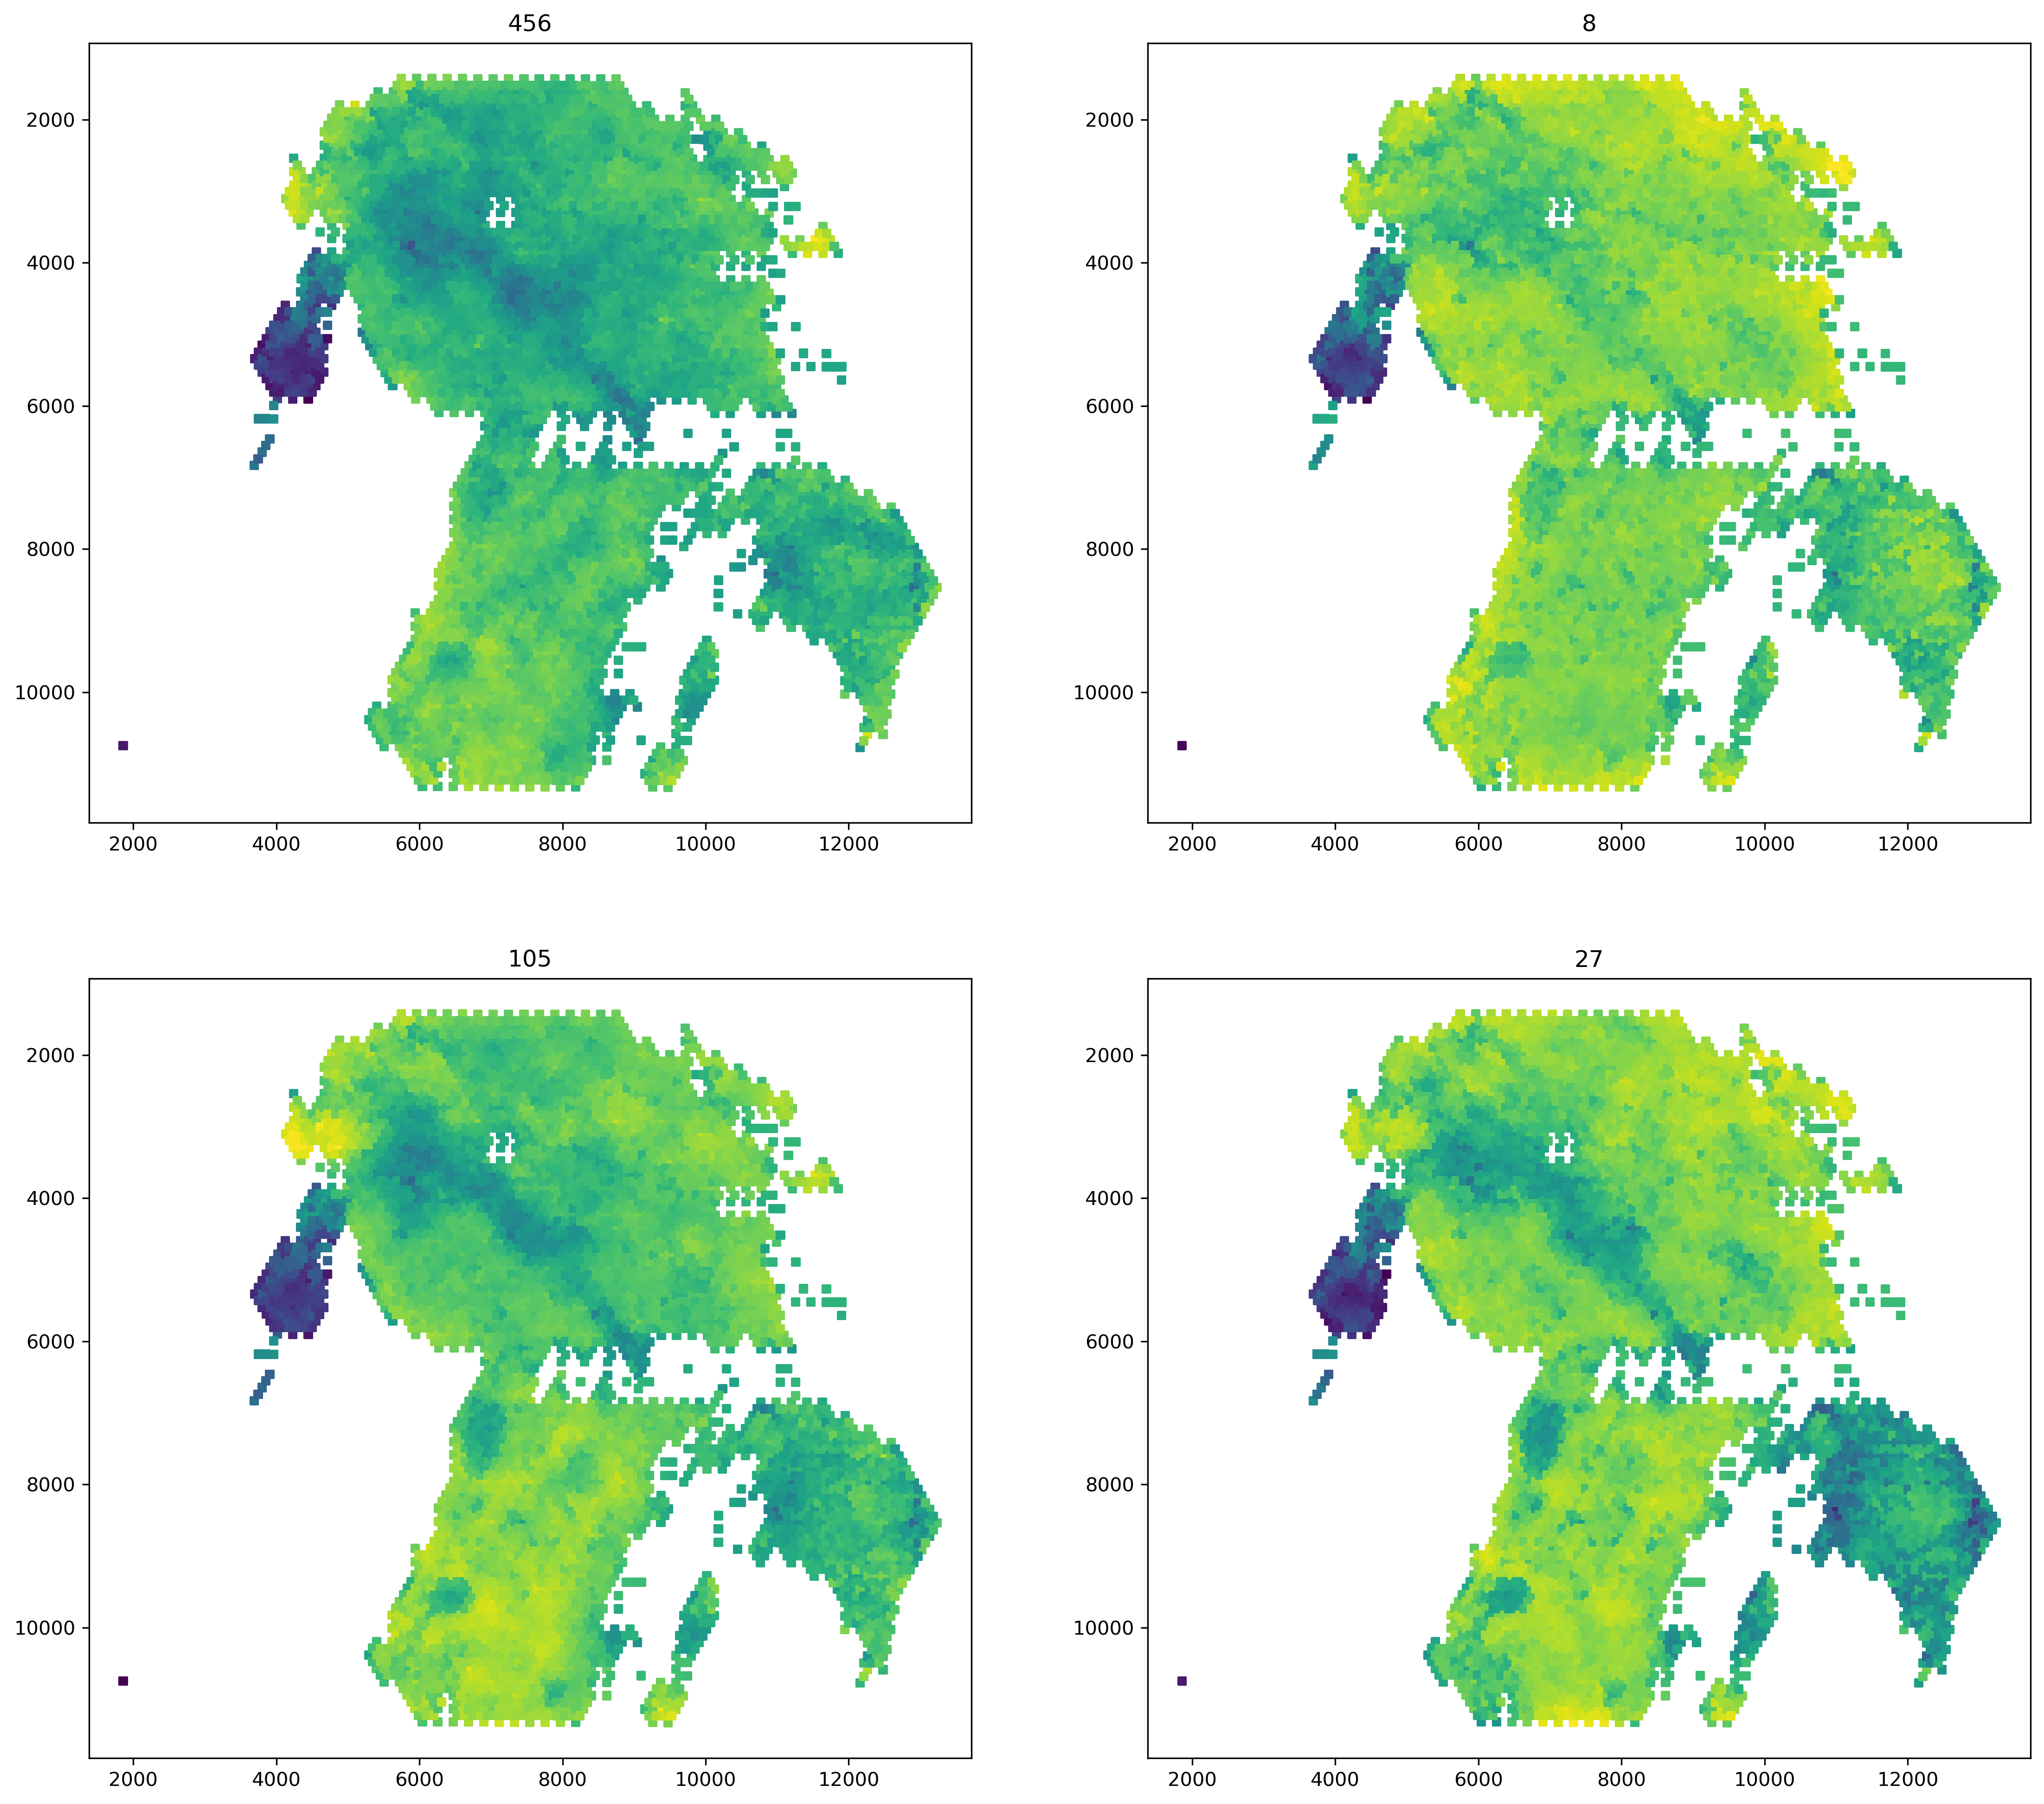

In [8]:
plot_clusters(gaussian_0)

# NPC1-ligand receptor pair

In [9]:
spot_diameter_fullres = 127.8358082731091
l = spot_diameter_fullres
cutoff = 0.001

single_cell = False
n_nearest_neighbors = 6 
n_neighbors = None, 
n_neighbors = n_nearest_neighbors * 31

l = spot_diameter_fullres
cutoff = 0.001 
n_neighbors=None  
n_nearest_neighbors=6
single_cell=False


## large neighborhood for W (5 layers)
from sklearn.neighbors import NearestNeighbors
def _Euclidean_to_RBF(X, l, singlecell=single_cell):
    """Convert Euclidean distance to RBF distance"""
    from scipy.sparse import issparse
    if issparse:
        rbf_d = X
        rbf_d[X.nonzero()] = np.exp(-X[X.nonzero()].A**2 / (2 * l ** 2))
    else:
        rbf_d = np.exp(- X**2 / (2 * l ** 2))
    # At single-cell resolution, no within-spot communications
    if singlecell:
        np.fill_diagonal(rbf_d, 0)
    else:
        rbf_d.setdiag(np.exp(-X.diagonal()**2 / (2 * l ** 2)))
    return rbf_d


adata_impt_all.uns['single_cell'] = single_cell
if isinstance(adata_impt_all.obsm['spatial'], pd.DataFrame):
    X_loc = adata_impt_all.obsm['spatial'].values
else:
    X_loc = adata_impt_all.obsm['spatial']

if n_neighbors is None:
    n_neighbors = n_nearest_neighbors * 31


## large neighborhood for W (5 layers)
nnbrs = NearestNeighbors(
    n_neighbors=n_neighbors,
    algorithm='ball_tree', 
    metric='euclidean'
).fit(X_loc)
nbr_d = nnbrs.kneighbors_graph(X_loc, mode='distance')
rbf_d = _Euclidean_to_RBF(nbr_d, l, single_cell)


## small neighborhood for RBF
nnbrs0 = NearestNeighbors(
    n_neighbors=n_nearest_neighbors, 
    algorithm='ball_tree', 
    metric='euclidean'
).fit(X_loc)
nbr_d0 = nnbrs0.kneighbors_graph(X_loc, mode='distance')
rbf_d0 = _Euclidean_to_RBF(nbr_d0, l, single_cell)


if cutoff:
    nonzero_mask = np.array(rbf_d[rbf_d.nonzero()] < cutoff)[0]
    rows = rbf_d.nonzero()[0][nonzero_mask]
    cols = rbf_d.nonzero()[1][nonzero_mask]
    rbf_d[rows, cols] = 0

adata_impt_all.obsp['weight'] = rbf_d * adata_impt_all.shape[0] / rbf_d.sum()
adata_impt_all.obsp['nearest_neighbors'] = rbf_d0 * adata_impt_all.shape[0] / rbf_d0.sum()

In [10]:
sdm.extract_lr(adata_impt_all, 'human', min_cell=3)      # find overlapping LRs from CellChatDB
print(adata_impt_all)

AnnData object with n_obs × n_vars = 5039 × 596
    obs: 'x', 'y'
    uns: 'geneInter', 'local_stat', 'local_z', 'local_z_p', 'selected_spots', 'single_cell', 'mean', 'ligand', 'receptor', 'num_pairs'
    obsm: 'spatial'
    obsp: 'nearest_neighbors', 'weight'


In [11]:
sdm.spatialdm_global(adata_impt_all, n_perm=1000, specified_ind=None, method='z-score', nproc=1)     # global Moran selection
sdm.sig_pairs(adata_impt_all, method='z-score', fdr=True, threshold=0.1)     # select significant pairs

In [12]:
adata_impt_all.raw = adata_impt_all

import time
start = time.time()
sdm.spatialdm_local(adata_impt_all, n_perm=1000, method='z-score', specified_ind=None, nproc=1)     # local spot selection
sdm.sig_spots(adata_impt_all, method='z-score', fdr=False, threshold=0.1)     # significant local spots
print("%.3f seconds" %(time.time()-start))

2.582 seconds


In [13]:
print(adata_impt_all)
adata_impt_all.uns["local_z_p"]

AnnData object with n_obs × n_vars = 5039 × 596
    obs: 'x', 'y'
    uns: 'geneInter', 'local_stat', 'local_z', 'local_z_p', 'selected_spots', 'single_cell', 'mean', 'ligand', 'receptor', 'num_pairs', 'global_I', 'global_stat', 'global_res'
    obsm: 'spatial'
    obsp: 'nearest_neighbors', 'weight'


0         1         2         3         4         5  \
EFNA5_EPHB2  0.812734  1.000000  1.000000  1.000000  1.000000  0.889804   
EFNB1_EPHA4  1.000000  0.475286  0.999987  0.461302  0.468892  0.512731   
EFNB1_EPHB1  1.000000  0.697025  0.408778  0.451858  0.676784  0.638709   
EFNB1_EPHB2  1.000000  0.585721  1.000000  0.460501  0.689316  0.039573   
EFNB1_EPHB3  1.000000  0.600598  1.000000  0.587939  0.925723  0.579293   
...               ...       ...       ...       ...       ...       ...   
CCL3_CCR5    1.000000  1.000000  1.000000  1.000000  0.738358  0.581517   
CCL5_CCR5    1.000000  0.679945  1.000000  1.000000  0.916419  0.563568   
CCL4_CCR5    1.000000  1.000000  1.000000  1.000000  0.925827  0.606581   
CXCL1_ACKR1  0.538190  1.000000  0.295192  0.647770  1.000000  0.482652   
CORT_SSTR2   1.000000  1.000000  1.000000  0.750473  0.663453  0.631588   

                    6         7         8         9  ...      5029      5030  \
EFNA5_EPHB2  1.000000  1.000000  1.000000  1.000000  ...  0.358390  1.000000   
EFNB1_EPHA4  0.750120  0.960887  1.000000  1.000000  ...  1.000000  0.553294   
EFNB1_EPHB1  0.553805  1.000000  1.000000  0.641895  ...  1.000000  0.520049   
EFNB1_EPHB2  1.000000  1.000000  1.000000  1.000000  ...  0.529120  0.480523   
EFNB1_EPHB3  0.579617  1.000000  1.000000  1.000000  ...  0.525378  0.484624   
...               ...       ...       ...       ...  ...       ...       ...   
CCL3_CCR5    1.000000  0.554348  0.970124  1.000000  ...  0.032998  0.555073   
CCL5_CCR5    0.521150  0.511465  0.023366  0.537434  ...  0.437113  0.713286   
CCL4_CCR5    1.000000  0.468196  0.000412  0.590434  ...  0.264310  0.668238   
CXCL1_ACKR1  1.000000  1.000000  1.000000  1.000000  ...  1.000000  1.000000   
CORT_SSTR2   0.332404  1.000000  0.588205  1.000000  ...  1.000000  1.000000   

                 5031      5032      5033      5034      5035      5036  \
EFNA5_EPHB2  1.000000  0.612942  0.604228  1.000000  0.504169  0.586477   
EFNB1_EPHA4  0.588101  0.535898  0.231551  0.405988  0.570580  0.565335   
EFNB1_EPHB1  0.752744  0.301209  0.117563  0.308463  0.149040  0.402738   
EFNB1_EPHB2  1.000000  0.431892  0.236407  0.521786  0.492014  0.401582   
EFNB1_EPHB3  1.000000  0.553284  0.681660  0.525871  0.314680  0.380428   
...               ...       ...       ...       ...       ...       ...   
CCL3_CCR5    0.570042  0.613510  0.512416  0.517058  1.000000  1.000000   
CCL5_CCR5    0.811502  0.779320  0.445735  0.486822  0.554086  1.000000   
CCL4_CCR5    0.844387  0.927276  0.359887  0.452005  0.551847  1.000000   
CXCL1_ACKR1  0.495441  1.000000  1.000000  1.000000  1.000000  1.000000   
CORT_SSTR2   1.000000  0.549938  0.736143  0.780080  0.499802  0.020597   

                 5037      5038  
EFNA5_EPHB2  0.494672  1.000000  
EFNB1_EPHA4  0.596308  0.628285  
EFNB1_EPHB1  0.158178  0.021182  
EFNB1_EPHB2  0.510983  0.664289  
EFNB1_EPHB3  0.799997  0.650086  
...               ...       ...  
CCL3_CCR5    0.490398  1.000000  
CCL5_CCR5    1.000000  1.000000  
CCL4_CCR5    1.000000  0.485147  
CXCL1_ACKR1  1.000000  1.000000  
CORT_SSTR2   0.682380  0.648617  

[786 rows x 5039 columns]

In [14]:
bin_spots = (1-adata_impt_all.uns["local_z_p"])[adata_impt_all.uns['local_stat']['n_spots']>2]
Y = bin_spots.to_numpy()

In [15]:
gaussian_1 = MixedGaussian(adata_impt_all.obsm['spatial'],group_size=16,d=30,l=1e-5)
cluster_1 = gaussian_1.run_cluster(Y.T,3,iter=50,init_mean='k_means') 

/mnt/jackywang/nfs_share/anaconda3/envs/biotransfer/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0
updating variance
Iteration 1


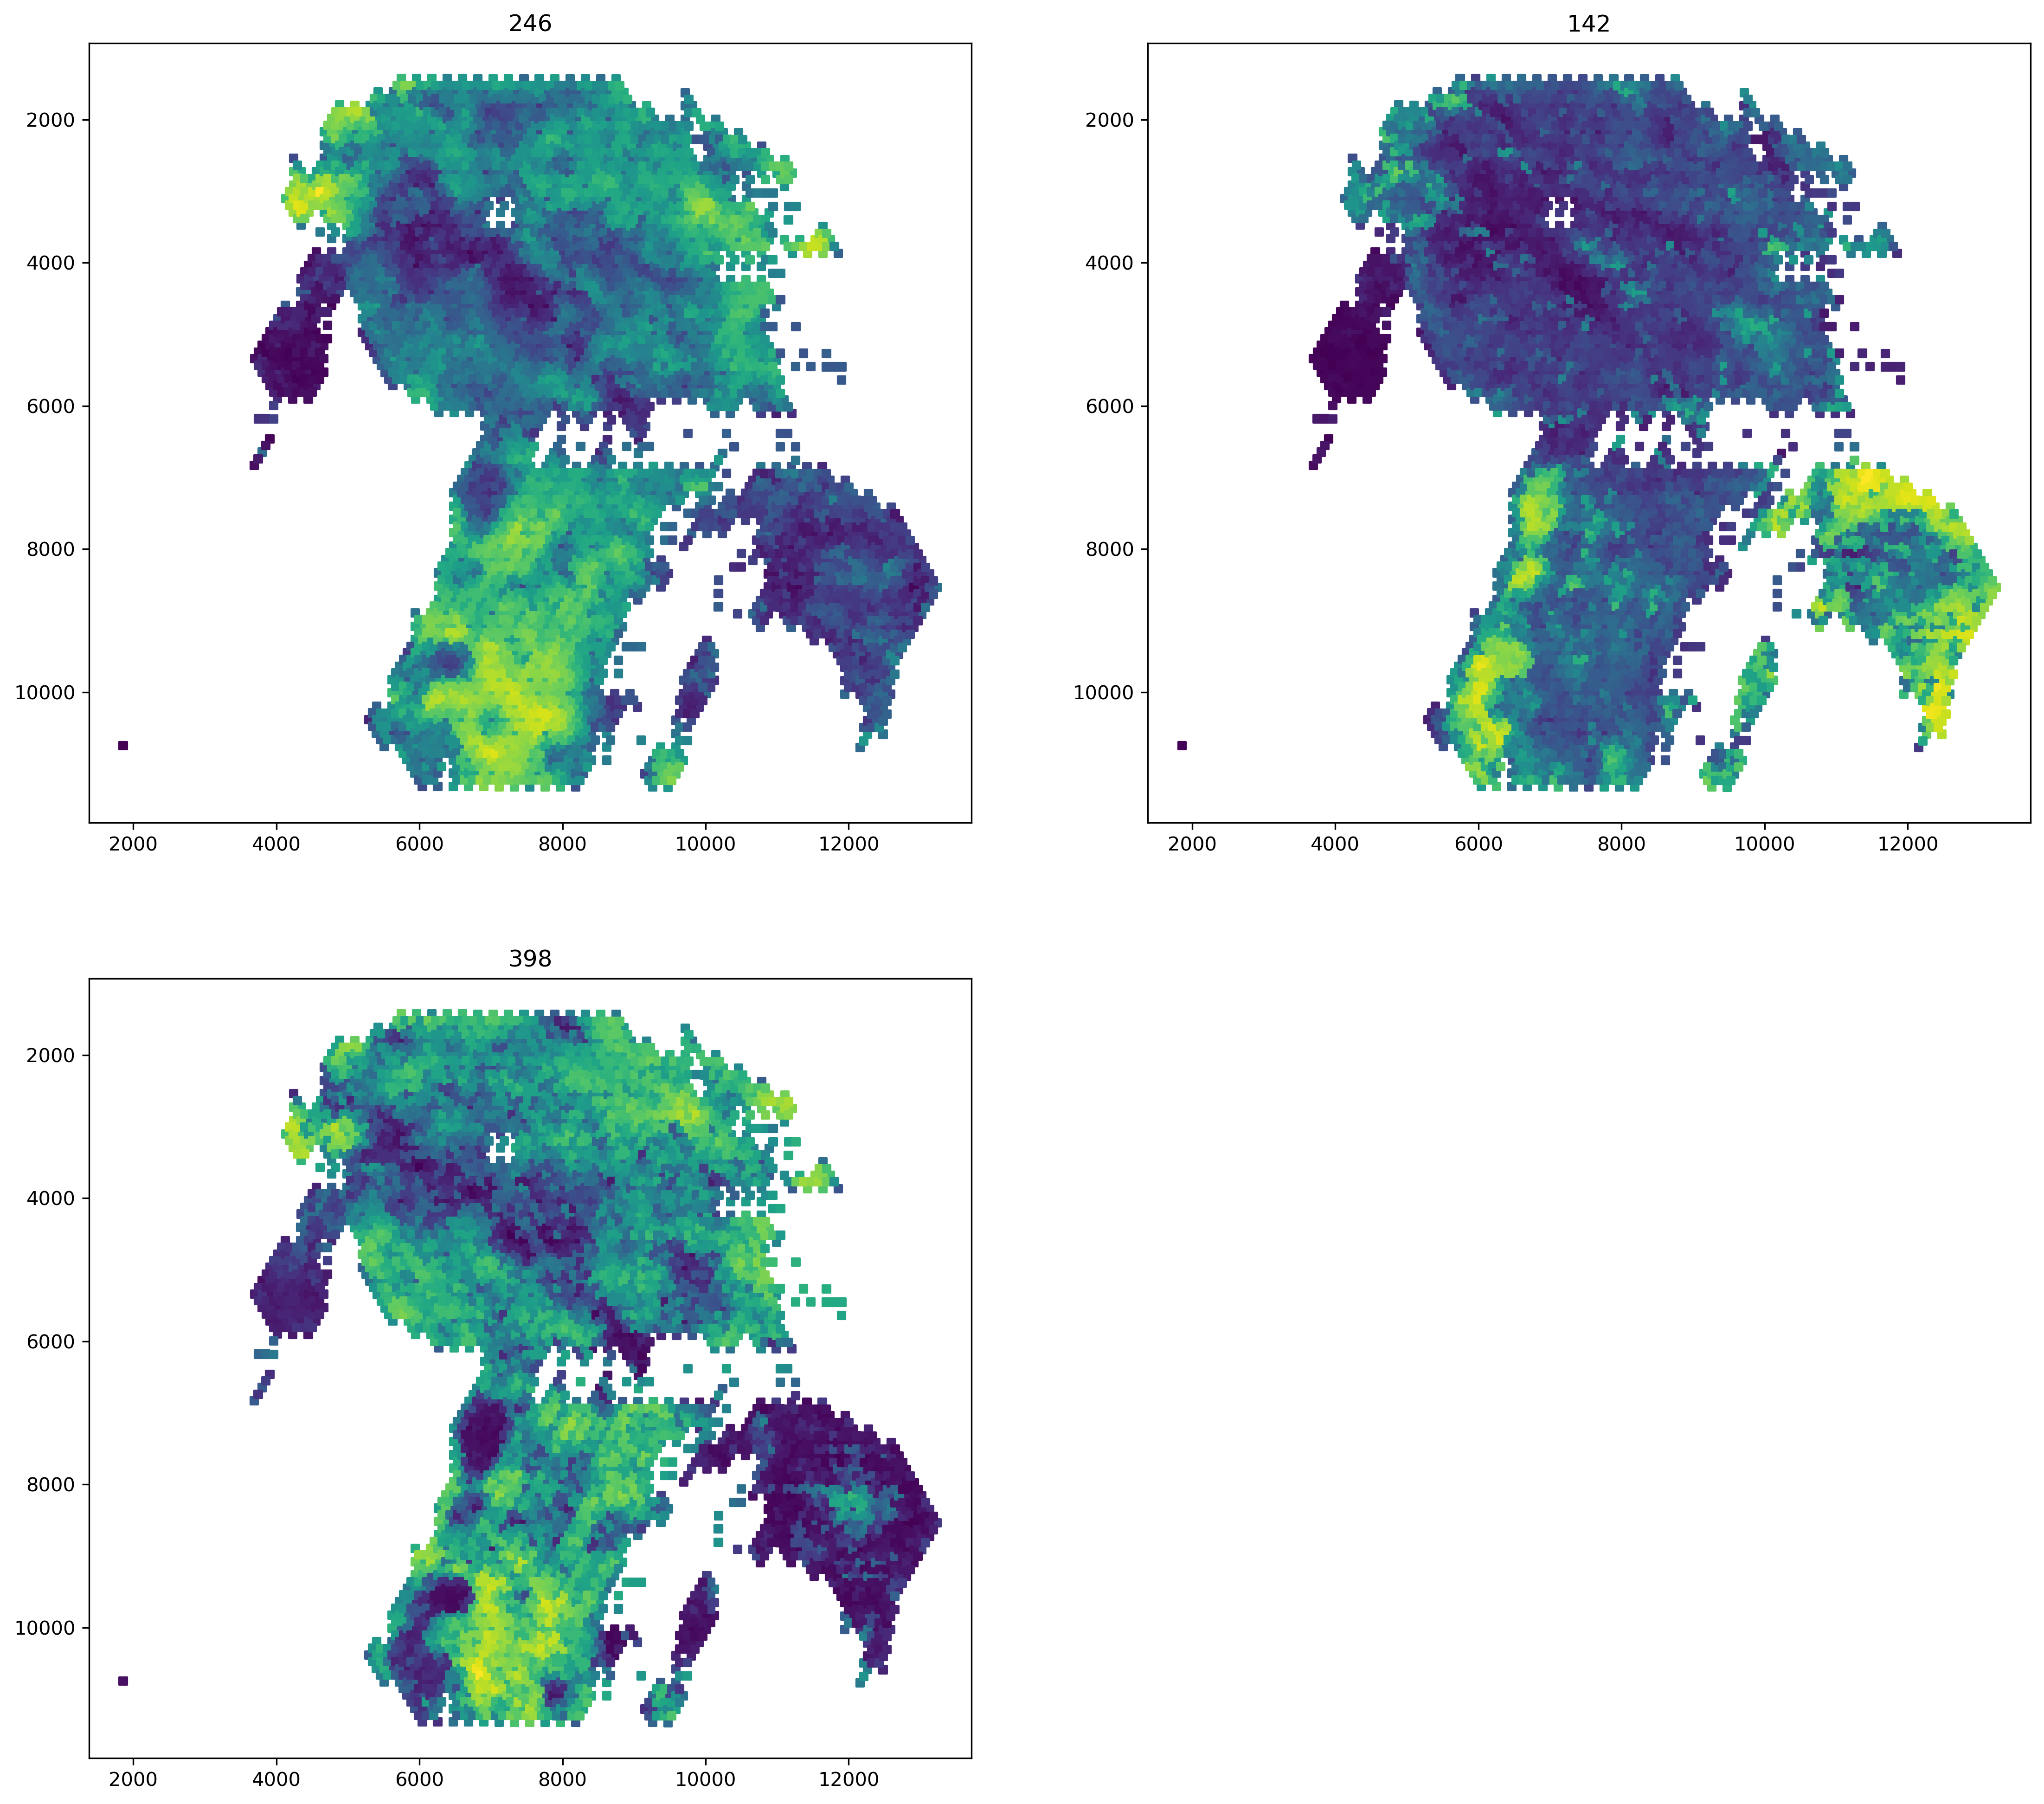

In [16]:
plot_clusters(gaussian_1)

# Visium HD - genes

In [17]:
from FineST.utils import *        
from FineST.datasets import dataset

#adata_impt_all = dataset.CRC_FineST()
adata_impt_all = dataset.CRC_Original()
adata_impt_all.obsm['spatial'] = np.column_stack((np.array(adata_impt_all.obs['array_row']), np.array(adata_impt_all.obs['array_col'])))
print(adata_impt_all)

AnnData object with n_obs × n_vars = 136954 × 862
    obs: 'array_row', 'array_col'
    obsm: 'spatial'


In [18]:
gaussian_2 = MixedGaussian(adata_impt_all.obsm['spatial'],group_size=16,d=30,l=1e-5)
cluster_2 = gaussian_2.run_cluster(adata_impt_all.X.toarray(),6,iter=50) 

/mnt/jackywang/nfs_share/anaconda3/envs/biotransfer/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0
updating variance
Iteration 1


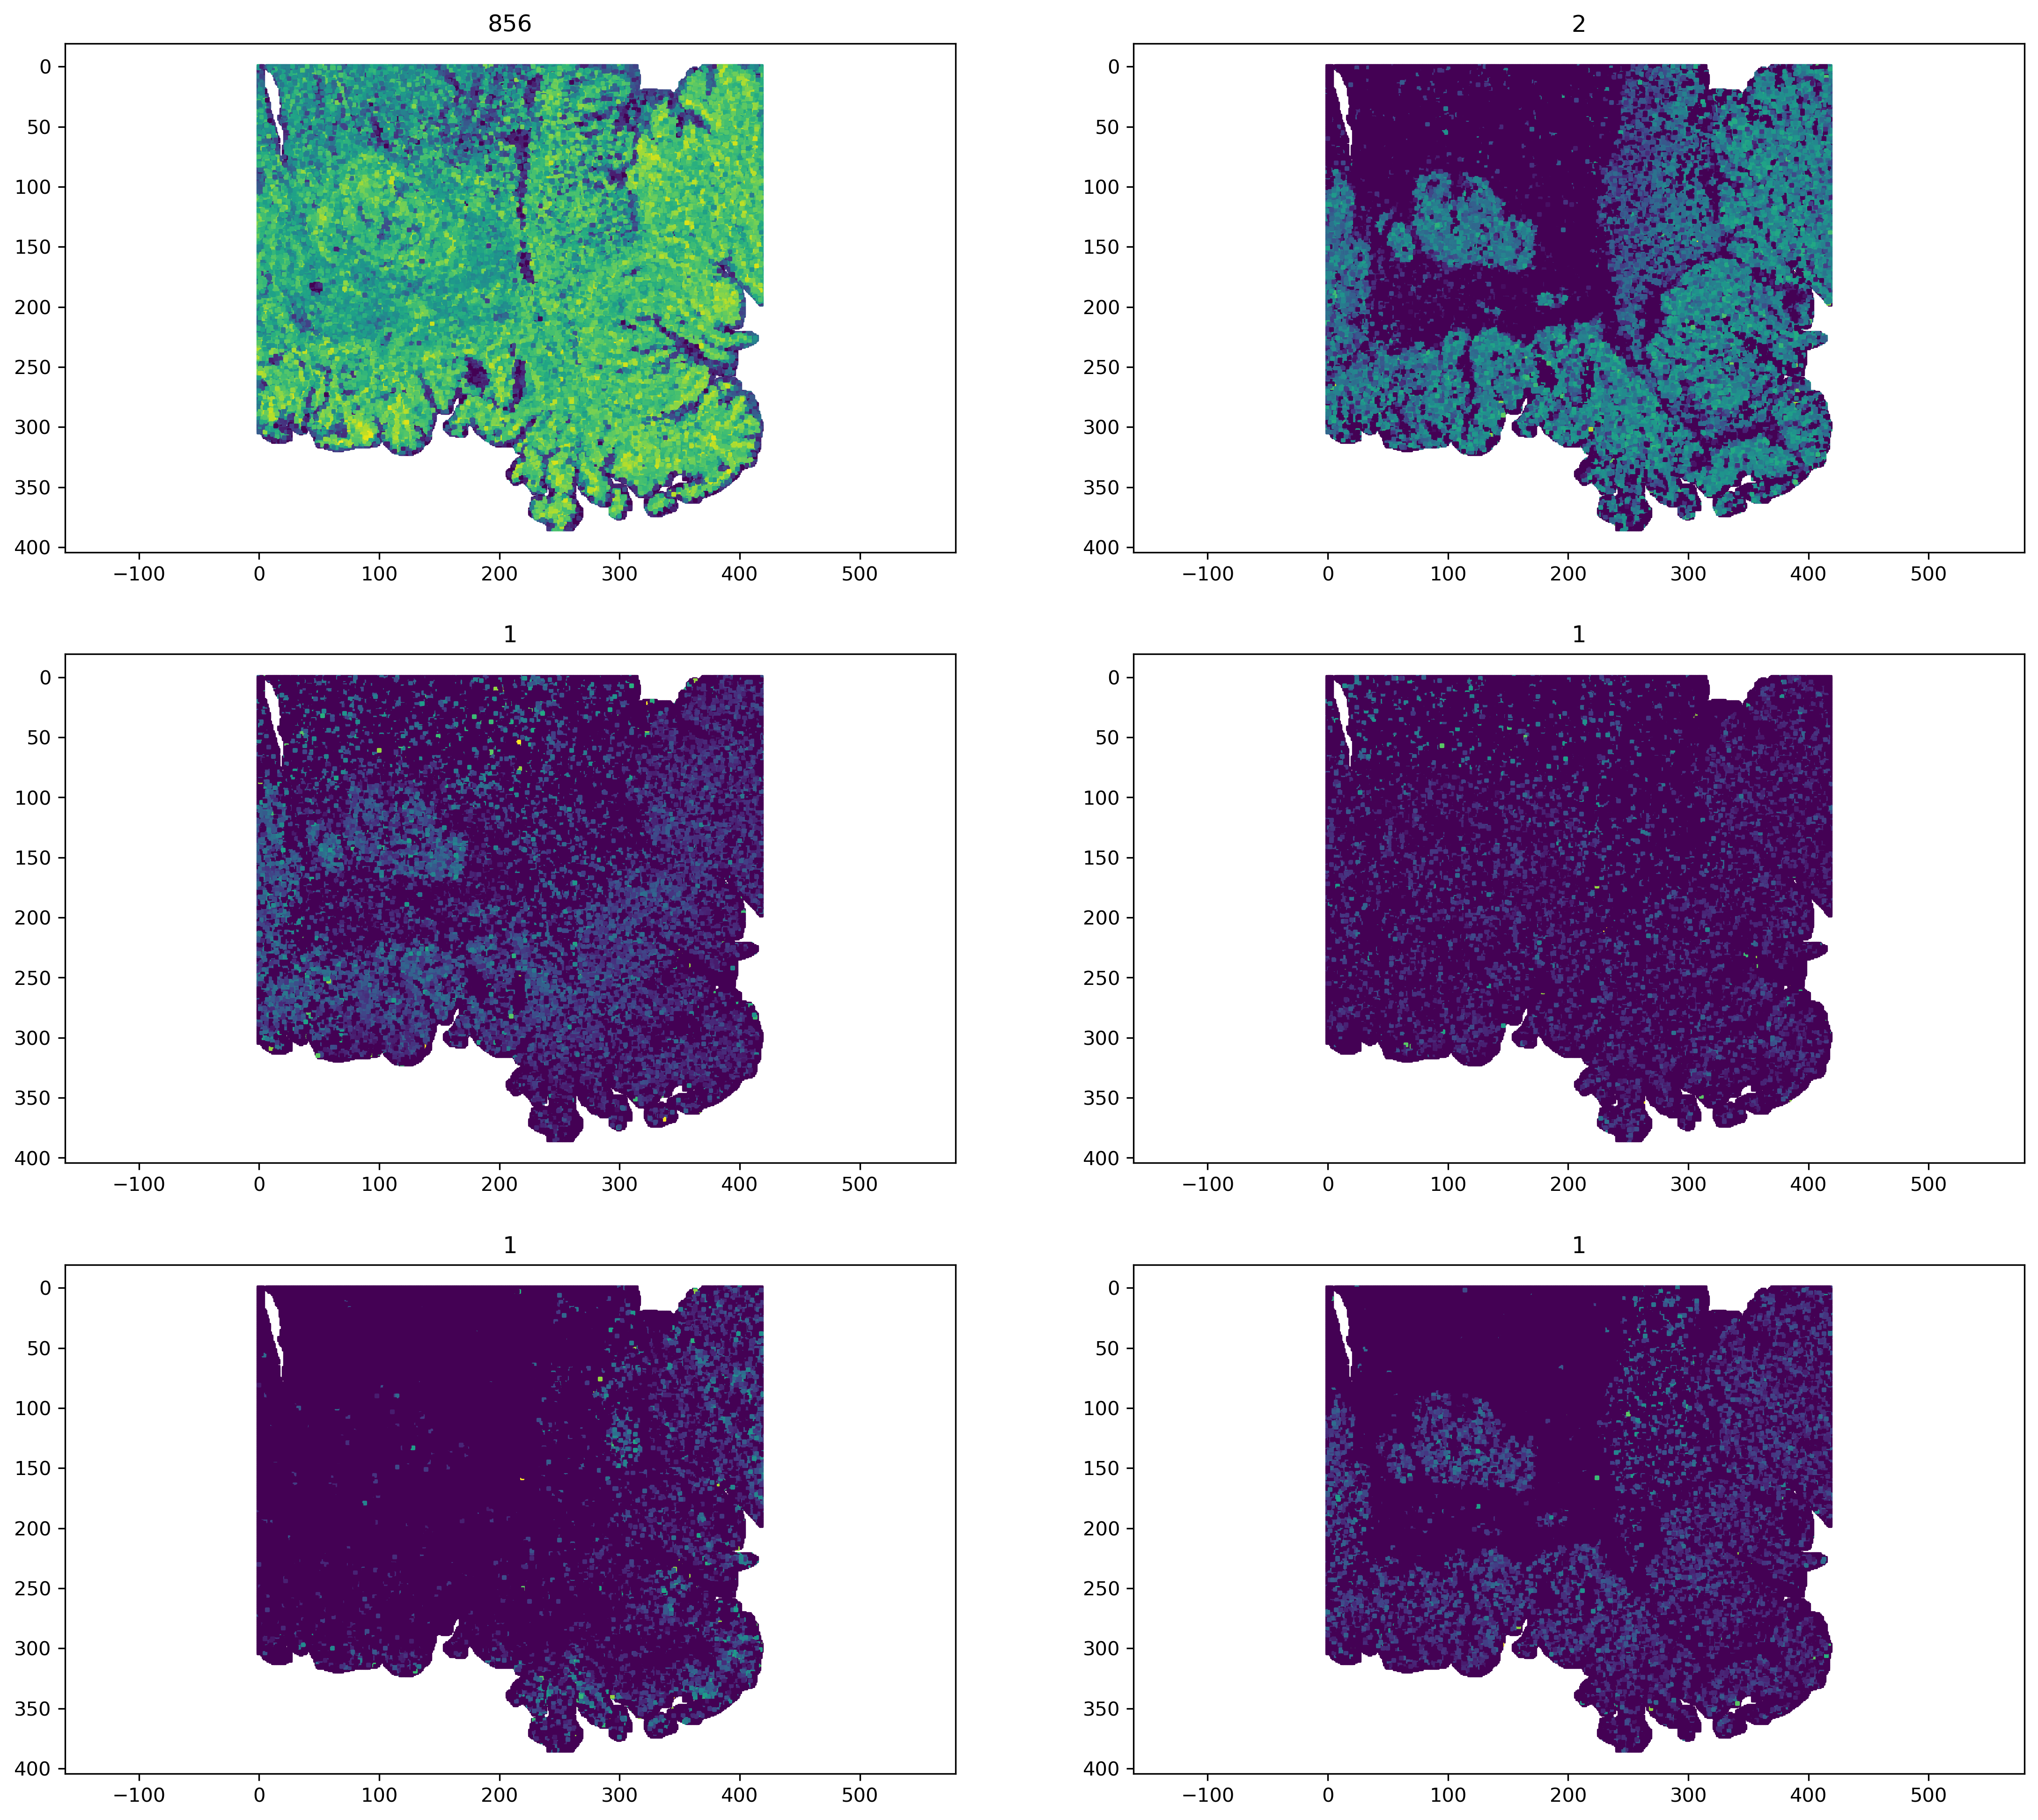

In [22]:
plot_clusters(gaussian_2,s=2)

# Visium HD - ligand receptor pair

In [ ]:
spot_diameter_fullres = 130    
l = spot_diameter_fullres
cutoff = 0.001
n_nearest_neighbors=6
single_cell=False
# n_neighbors=None  
n_neighbors = n_nearest_neighbors * 31

## large neighborhood for W (5 layers)
from sklearn.neighbors import NearestNeighbors
def _Euclidean_to_RBF(X, l, singlecell=single_cell):
    """Convert Euclidean distance to RBF distance"""
    from scipy.sparse import issparse
    if issparse:
        rbf_d = X
        rbf_d[X.nonzero()] = np.exp(-X[X.nonzero()].A**2 / (2 * l ** 2))
    else:
        rbf_d = np.exp(- X**2 / (2 * l ** 2))
    
    # At single-cell resolution, no within-spot communications
    if singlecell:
        np.fill_diagonal(rbf_d, 0)
    else:
        rbf_d.setdiag(np.exp(-X.diagonal()**2 / (2 * l ** 2)))

    return rbf_d


adata_impt_all.uns['single_cell'] = single_cell
if isinstance(adata_impt_all.obsm['spatial'], pd.DataFrame):
    X_loc = adata_impt_all.obsm['spatial'].values
else:
    X_loc = adata_impt_all.obsm['spatial']

if n_neighbors is None:
    n_neighbors = n_nearest_neighbors * 31


## large neighborhood for W (5 layers)
nnbrs = NearestNeighbors(
    n_neighbors=n_neighbors,
    algorithm='ball_tree', 
    metric='euclidean'
).fit(X_loc)
nbr_d = nnbrs.kneighbors_graph(X_loc, mode='distance')
rbf_d = _Euclidean_to_RBF(nbr_d, l, single_cell)


## small neighborhood for RBF
nnbrs0 = NearestNeighbors(
    n_neighbors=n_nearest_neighbors, 
    algorithm='ball_tree', 
    metric='euclidean'
).fit(X_loc)
nbr_d0 = nnbrs0.kneighbors_graph(X_loc, mode='distance')
rbf_d0 = _Euclidean_to_RBF(nbr_d0, l, single_cell)


if cutoff:
    nonzero_mask = np.array(rbf_d[rbf_d.nonzero()] < cutoff)[0]
    rows = rbf_d.nonzero()[0][nonzero_mask]
    cols = rbf_d.nonzero()[1][nonzero_mask]
    rbf_d[rows, cols] = 0


adata_impt_all.obsp['weight'] = rbf_d * adata_impt_all.shape[0] / rbf_d.sum()
adata_impt_all.obsp['nearest_neighbors'] = rbf_d0 * adata_impt_all.shape[0] / rbf_d0.sum()

In [ ]:
sdm.extract_lr(adata_impt_all, 'human', min_cell=3)      # find overlapping LRs from CellChatDB
print(adata_impt_all)

In [ ]:
sdm.spatialdm_global(adata_impt_all, n_perm=1000, specified_ind=None, method='z-score', nproc=1)     # global Moran selection
sdm.sig_pairs(adata_impt_all, method='z-score', fdr=True, threshold=0.1)     # select significant pairs

In [ ]:
sdm.spatialdm_local(adata_impt_all, n_perm=1000, method='z-score', specified_ind=None, nproc=1)     # local spot selection
sdm.sig_spots(adata_impt_all, method='z-score', fdr=False, threshold=0.1)     # significant local spots

In [ ]:
bin_spots = (1-adata_impt_all.uns["local_z_p"])[adata_impt_all.uns['local_stat']['n_spots']>2]
X = adata_impt_all.obsm['spatial']
exp_tab = bin_spots.transpose()

In [ ]:
gaussian_3 = MixedGaussian(spatial = adata_impt_all.obsm['spatial'],
                         cov=None, group_size=16, d=5, kernel='rbf', l=0.01)
gaussian_3.run_cluster(np.array(exp_tab), 6, iter=50)